In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tqdm
from math import sqrt
import seaborn as sns; sns.set()

In [3]:
file = open('./data/na62_11_pulses.txt', 'r')
data = file.readlines()
data = np.array([list(map(float, experiment.split())) for experiment in data])
y = data[:, 0]
y_baseline = data[:, 1]
X = data[:, 2:]

In [4]:
print("Number of samples:", X.shape[0])
print("Dimension of each sample:", X.shape[1])

Number of samples: 1207
Dimension of each sample: 1024


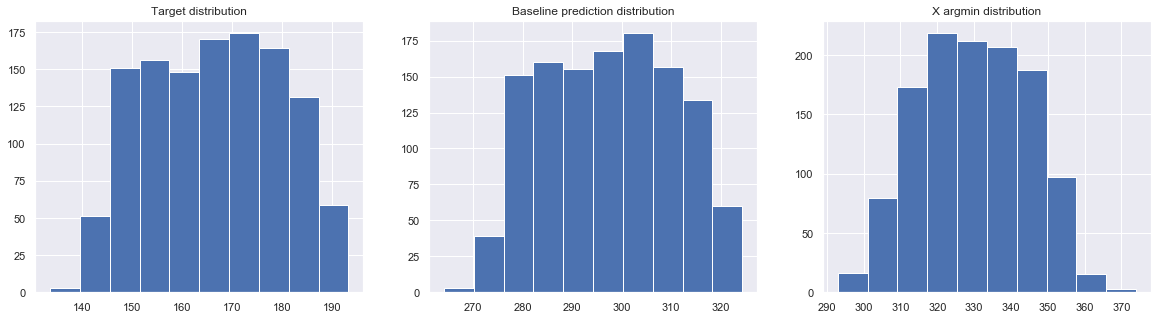

In [5]:
f, axarr = plt.subplots(1, 3, figsize=(20,5))
axarr[0].set_title("Target distribution")
axarr[0].hist(y)

axarr[1].set_title("Baseline prediction distribution")
axarr[1].hist(y_baseline)

axarr[2].set_title("X argmin distribution")
axarr[2].hist(np.argmin(X, axis=1))
plt.show()

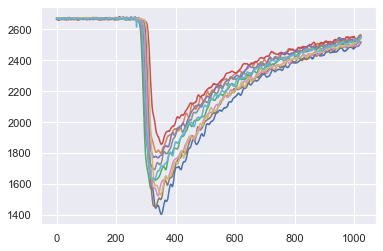

In [6]:
for i in range(10):
    plt.plot(X[i])
plt.show()

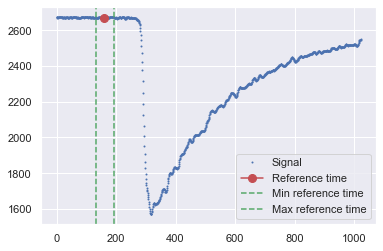

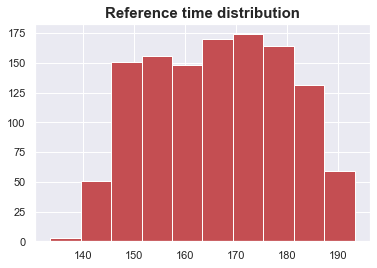

In [7]:
plt.plot(X[2], 'ro', color='b', markersize=1)
# plt.axvline(x=y[0], color='r')
plt.plot([int(y[2])], [X[2][int(y[2])]], color='r', marker='o', markersize=8)
# plt.show()
plt.axvline(x=np.min(y), color='g', linestyle='--')
plt.axvline(x=np.max(y), color='g', linestyle='--')
plt.legend(['Signal', 'Reference time', 'Min reference time', 'Max reference time'])
plt.show()
plt.title("Reference time distribution", weight='bold', fontsize=15)
plt.hist(y, color='r')
plt.show()

### Normalize y

In [8]:
X.shape

(1207, 1024)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


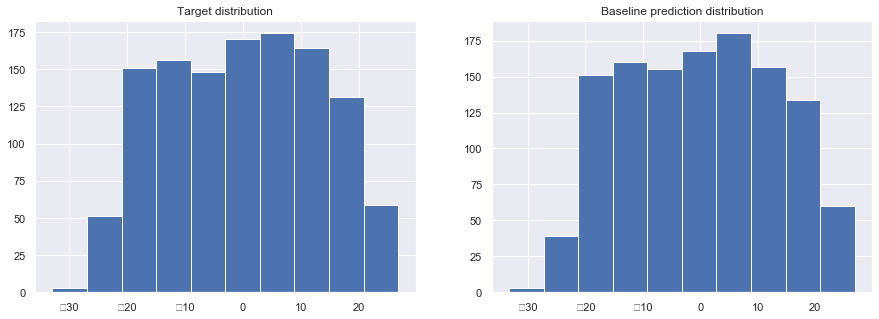

In [9]:
y = y - np.mean(y)
y_baseline = y_baseline - np.mean(y_baseline)

f, axarr = plt.subplots(1, 2, figsize=(15,5))
axarr[0].set_title("Target distribution")
axarr[0].hist(y)

axarr[1].set_title("Baseline prediction distribution")
axarr[1].hist(y_baseline)
plt.show()

### Model

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.preprocessing import PolynomialFeatures

In [11]:
TIME_SCALE_COEF = 0.2

def print_model_scores(X, y, model=LinearRegression()):
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X, y, scoring=scoring, cv=5)
    
    print("95% confidence interval:")
    print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
    print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
    print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
    print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

##### Linear regression metrics

In [12]:
X = np.array([experiment - np.max(experiment) for experiment in X])
X = np.array([experiment/-np.min(experiment) for experiment in X])    

In [13]:
samples_sizes = range(100, 1000, 50)
rmse_scores = []
model=LinearRegression()

for samples_size in tqdm.tqdm(samples_sizes):
    X_new = X[:, :samples_size]
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X_new, y, scoring=scoring, cv=5)
    rmse_scores.append(TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean())

100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


In [14]:
print(list(samples_sizes))

[100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]


In [15]:
np.argmin(rmse_scores)

5

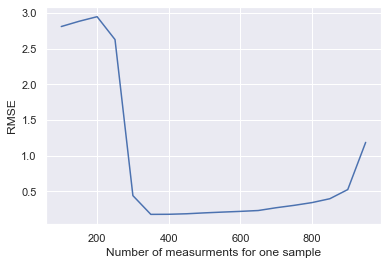

In [16]:
plt.plot(samples_sizes, rmse_scores)
plt.ylabel("RMSE")
plt.xlabel("Number of measurments for one sample")
plt.show()

In [17]:
print_model_scores(X[:, :360], y)

95% confidence interval:
r2_score: 0.99547 (+/- 0.00164)
MSE[ns^2]: 0.03088 (+/- 0.05936)
RMSE[ns]: 0.17499 (+/- 0.03208)
MAE[ns]: 0.13427 (+/- 0.01180)


In [18]:
print_model_scores(X, y)

95% confidence interval:
r2_score: 0.95025 (+/- 0.02731)
MSE[ns^2]: 0.33791 (+/- 0.88018)
RMSE[ns]: 0.57627 (+/- 0.15263)
MAE[ns]: 0.44539 (+/- 0.09785)


In [19]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
model.coef_

array([ 27272.6195189 , -27299.04448604,     39.43882113, ...,
          -59.78293666,    -42.13586933,     32.93335666])

##### Baseline metrics

In [21]:
print("Baseline metric:")
print("r2_score:", np.round(r2_score(y, y_baseline), decimals=5))
print("MSE[ns^2]:", np.round(TIME_SCALE_COEF**2 * mean_squared_error(y, y_baseline), decimals=5))
print("RMSE[ns]:", np.round(TIME_SCALE_COEF * sqrt(mean_squared_error(y, y_baseline)), decimals=5))
print("MAE[ns]:", np.round(TIME_SCALE_COEF * mean_absolute_error(y, y_baseline), decimals=5))

Baseline metric:
r2_score: 0.99861
MSE[ns^2]: 0.00951
RMSE[ns]: 0.09752
MAE[ns]: 0.07702


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


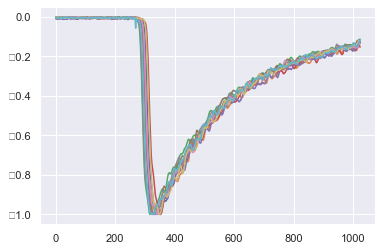

In [22]:
for i in range(10):
    plt.plot(X[i])

In [23]:
amplitude_half = np.min(X[0]) + (np.max(X[0] - np.min(X[0])))/2

### Feature engineering

In [24]:
half_implitude_locs = []

for signal in tqdm.tqdm(X):
    amplitude_half = np.min(signal) + (np.max(signal - np.min(signal)))/2
    cur_imp = signal[0]
    for i in range(1, len(signal)):
        next_imp = signal[i]

        if cur_imp > amplitude_half and amplitude_half >= next_imp:
            break
        cur_imp = next_imp
    half_implitude_locs.append(i)

100%|██████████| 1207/1207 [00:00<00:00, 6881.32it/s]


In [25]:
from scipy.stats.stats import pearsonr   

pearsonr(half_implitude_locs, y)

(0.9990222485525273, 0.0)

In [26]:
len(X)

1207

In [27]:
len(half_implitude_locs)

1207

In [28]:
X.shape

(1207, 1024)

In [29]:
X_new = np.zeros((X.shape[0], X.shape[1] + 1))

In [30]:
for i in range(len(X)):
    X_new[i] = np.append(X[i], [half_implitude_locs[i]])

In [31]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster='gbtree', eta=0.040967242033212566, 
                               gamma=0.11403358374490781, max_depth=42, reg_lambda=0.0010412564895330462,
                               alpha=9.720814421482372, verbosity=0)

In [32]:
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
scores = cross_validate(xgb_reg, X, y, scoring=scoring, cv=5)

print("95% confidence interval:")
print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

95% confidence interval:
r2_score: 0.99768 (+/- 0.00111)
MSE[ns^2]: 0.01582 (+/- 0.04030)
RMSE[ns]: 0.12482 (+/- 0.03096)
MAE[ns]: 0.08865 (+/- 0.00870)


In [33]:
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
scores = cross_validate(xgb_reg, X_new, y, scoring=scoring, cv=5)

print("95% confidence interval:")
print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

95% confidence interval:
r2_score: 0.99768 (+/- 0.00111)
MSE[ns^2]: 0.01582 (+/- 0.04030)
RMSE[ns]: 0.12482 (+/- 0.03096)
MAE[ns]: 0.08865 (+/- 0.00870)


In [34]:
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
scores = cross_validate(xgb_reg, np.array(half_implitude_locs).reshape(-1, 1), y, scoring=scoring, cv=5)

print("95% confidence interval:")
print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

95% confidence interval:
r2_score: 0.99778 (+/- 0.00058)
MSE[ns^2]: 0.01512 (+/- 0.01980)
RMSE[ns]: 0.12273 (+/- 0.01568)
MAE[ns]: 0.09548 (+/- 0.00528)


In [35]:
from common import get_freq_data

In [36]:
plt.plot(X_freq[0])

NameError: name 'X_freq' is not defined

In [58]:
pearsonr(np.argmin(X, axis=1), y)

(0.9013870868546854, 0.0)

(array([  3.,  38., 149., 157., 156., 165., 179., 160., 139.,  61.]),
 array([265., 271., 277., 283., 289., 295., 301., 307., 313., 319., 325.]),
 <a list of 10 Patch objects>)

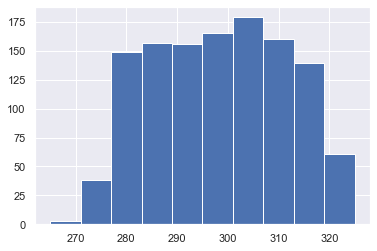

In [52]:
plt.hist(half_implitude_locs)

In [45]:
signal = X[0]

amplitude_half = np.min(signal) + (np.max(signal - np.min(signal)))/2
cur_imp = signal[0]
for i in range(1, len(signal)):
    next_imp = signal[i]
    
    if cur_imp > amplitude_half and amplitude_half >= next_imp:
        break
    cur_imp = next_imp

In [46]:
i

309